# Visualise Prediction Performance

In [1]:
FSETS=['f2f','f2fsr','sumpb','combi']
SPLITS=['instance','class']
DIR='../data/xtra-berlin'
CONFNAME="config.yaml"
_nomenclature = {'sumpb' : 'lipb', 'vbc' : 'VB', 'sbc' : 'SB', 'def' : 'Def'}
FIGOUT='/tmp/pred-times.pdf'
WIDTH_IN=4.5

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from scipy import stats
import seaborn as sns
import yaml

conf = yaml.load(open(os.path.join(DIR,CONFNAME)),Loader=yaml.Loader)
ptimes = pd.read_csv(f'{DIR}/eval-alltimes.csv.gz')
ptimes.columns = [c.replace("time_","") for c in ptimes.columns]
ptimes = ptimes.drop(columns=['ID','vwc']+conf['featuresets'])
ptimes.columns = [c.replace("_fe","") for c in ptimes.columns]

        split  cycle selector  timeouts
0       class      1    combi        13
1       class      2    combi         0
2       class      3    combi         0
3       class      4    combi         4
4       class      5    combi         7
..        ...    ...      ...       ...
695  instance     46      def         7
696  instance     47      def         6
697  instance     48      def         7
698  instance     49      def         5
699  instance     50      def         4

[700 rows x 4 columns]


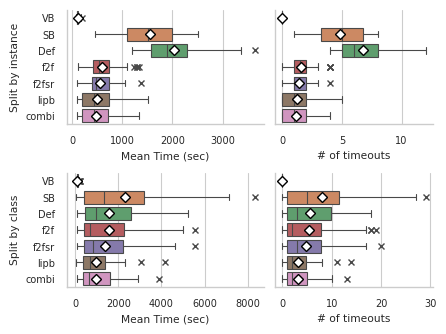

In [5]:
sns.set(
        context="paper", style="ticks", font_scale=0.8,
        rc={
            "font.family": "sans-serif",
            "lines.linewidth"  : 0.8,
        }
)
_meanprops = {"marker":"D", "markersize":5,
              "markerfacecolor":"white",
              "markeredgecolor":"black",
               "linewidth":1}
_flierprops = {'marker':'x'}

with sns.axes_style("whitegrid"):
    fig,axs=plt.subplots(2,2,sharex=False,sharey=True,width_ratios=(5,4),figsize=(WIDTH_IN,0.75*WIDTH_IN))

    plotdata = ptimes.groupby(['split','cycle']).mean().reset_index()
    p = plotdata.melt(id_vars=['split','cycle'],value_name='time',var_name='selector')
    for _f, _t in _nomenclature.items():
        p['selector'] = p.selector.str.replace(re.compile(_f),_t)

    for row, split in enumerate(SPLITS):
        _ax = axs[row,0]
        data = p.loc[p.split==split]
        sns.despine(ax=_ax)
        g = sns.boxplot(
            ax=_ax, data=data, y='selector', x='time', 
            showmeans=True, meanprops=_meanprops, flierprops=_flierprops,
            order=['VB','SB','Def','f2f','f2fsr','lipb','combi'],
        )
        g.set(xlabel="Mean Time (sec)", ylabel=f"Split by {split}")

    tos = pd.concat(
        [ptimes.groupby(['split','cycle'])[f].apply(lambda x:sum(x>conf['total_timeout']))
        for f in ptimes.columns if f not in ['split','cycle']
        ],
        axis=1
    ).reset_index()
    p = tos.melt(id_vars=['split','cycle'],value_name='timeouts',var_name='selector')
    print(p)
    for _f, _t in _nomenclature.items():
        p['selector'] = p.selector.str.replace(re.compile(_f),_t)

    for row, split in enumerate(SPLITS):
        _ax = axs[row,1]
        data = p.loc[p.split==split]
        sns.despine(ax=_ax)
        g = sns.boxplot(
            ax=_ax, data=data, y='selector', x='timeouts', 
            showmeans=True, meanprops=_meanprops, flierprops=_flierprops,
            order=['VB','SB','Def','f2f','f2fsr','lipb','combi'],
        )
        g.set(xlabel="# of timeouts", ylabel=None)

    fig.tight_layout()
    fig.savefig(FIGOUT,dpi=1200)
    plt.show()

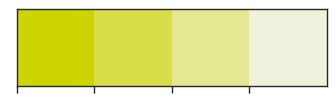

In [3]:
sns.palplot(sns.light_palette('#ccd500',n_colors=4,reverse=True))

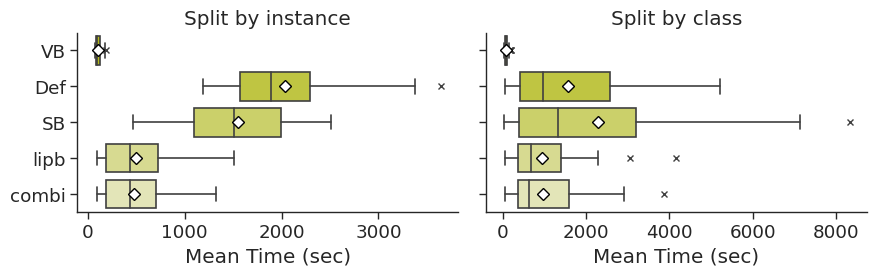

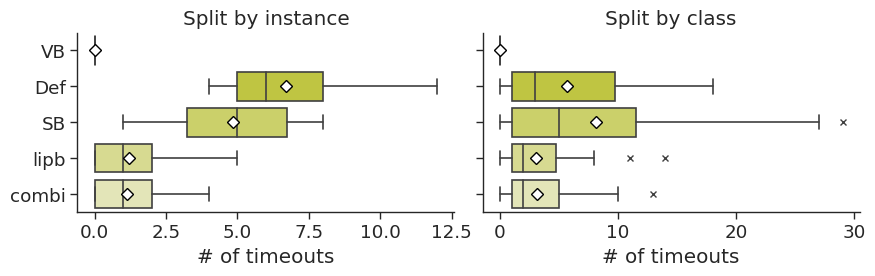

In [4]:
DK_COL='#1e2730'
LT_COL='#ccd500'
LT_RGB=(204/256,213/256,0)
sns.set(
    context="paper", style="ticks", font_scale=1.5,
)
plt.rcParams.update({
    "text.usetex" : False,
    "font.family": "sans-serif",
    "grid.linewidth": 0.5,
    "lines.linewidth" : 1.2,
    "lines.color" : DK_COL,
})

_meanprops = {"marker":"D",
              "markerfacecolor":"white",
              "markeredgecolor":"black",
               "linewidth":1,
             }
_flierprops = {'marker':'x'}

fig,axs=plt.subplots(1,2,figsize=(9,3),sharex=False,sharey=True)

plotdata = ptimes.groupby(['split','cycle']).mean().reset_index()
p = plotdata.melt(id_vars=['split','cycle'],value_name='time',var_name='selector')
for _f, _t in _nomenclature.items():
    p['selector'] = p.selector.str.replace(re.compile(_f),_t)

use_sels = ['VB', 'Def', 'SB', 'lipb', 'combi']
for col,split in enumerate(SPLITS):
    _ax = axs[col]
    data = p.loc[(p.split==split)&p.selector.isin(use_sels)]
    sns.despine(ax=_ax)
    g = sns.boxplot(
        ax=_ax, data=data, y='selector', x='time', 
        showmeans=True, meanprops=_meanprops, flierprops=_flierprops,
        order=use_sels,
        palette=sns.light_palette(LT_COL,reverse=True,n_colors=6 ),
    )
    _ax.set(xlabel="Mean Time (sec)", title=f"Split by {split}",
           ylabel=None)
fig.tight_layout()
fig.savefig("/tmp/predtimes-poster.pdf",dpi=1200)
plt.show()


tos = pd.concat(
    [ptimes.groupby(['split','cycle'])[f].apply(lambda x:sum(x>conf['total_timeout']))
    for f in ptimes.columns if f not in ['split','cycle']
    ],
    axis=1
).reset_index()
p = tos.melt(id_vars=['split','cycle'],value_name='timeouts',var_name='selector')
for _f, _t in _nomenclature.items():
    p['selector'] = p.selector.str.replace(re.compile(_f),_t)
fig,axs=plt.subplots(1,2,figsize=(9,3),sharex=False,sharey=True)

for col, split in enumerate(SPLITS):
    _ax = axs[col]
    data = p.loc[(p.split==split)&p.selector.isin(use_sels)]
    sns.despine(ax=_ax)
    g = sns.boxplot(
        ax=_ax, data=data, y='selector', x='timeouts', 
        showmeans=True, meanprops=_meanprops, flierprops=_flierprops,
        order=use_sels,
        palette=sns.light_palette(LT_COL,reverse=True,n_colors=6 ),
    )
    _ax.set(title=f"Split by {split}", xlabel="# of timeouts", ylabel=None)

fig.tight_layout()
fig.savefig("/tmp/timeouts-poster.pdf",dpi=1200)
plt.show()
